In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import mlflow

np.set_printoptions(precision=3, suppress=True)
tf.__version__

'2.4.1'

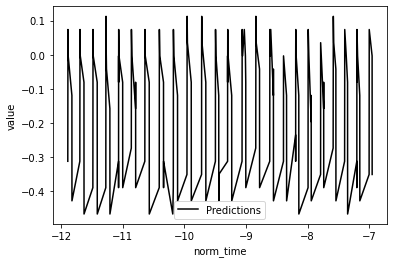

In [42]:
# Read dataset from file
raw_dataset = pd.read_csv("./data_grouped/1161114002_122.csv")
raw_dataset = raw_dataset.astype({'id':'float','value':'float', 'station_id':'int', 'parameter_id':'int', 'unix_timestamp':'int', 'norm_time':'float'})
dataset = raw_dataset.copy()
dataset = dataset.dropna().drop(['id','station_id','parameter_id','unix_timestamp'], axis=1)
dataset_full = dataset.sort_values(by=['norm_time'])
dataset = dataset_full[0:300]
dataset
# 

plt.plot(dataset['norm_time'], dataset['norm_value'], color='k', label='Predictions')
plt.xlabel('norm_time')
plt.ylabel('value')
plt.legend()
plt.show()

In [43]:
test_data = dataset_full[301:600]

In [44]:
serial_data = dataset.drop(['value','norm_time'], axis=1)
serial_data['norm_1'] = serial_data['norm_value'].shift(1)
serial_data['norm_2'] = serial_data['norm_value'].shift(2)
serial_data['norm_3'] = serial_data['norm_value'].shift(3)
serial_data['norm_4'] = serial_data['norm_value'].shift(4)
serial_data['norm_5'] = serial_data['norm_value'].shift(5)
serial_data['norm_6'] = serial_data['norm_value'].shift(6)
serial_data = serial_data[6:]
serial_data
# serial_data.to_csv("./1161114002_122_norm.csv", index=False)

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
6,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.311759
7,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
8,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
9,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110,-0.080272
10,-0.350340,-0.273178,-0.196016,-0.118853,-0.003110,0.074052,-0.003110
...,...,...,...,...,...,...,...
295,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597,-0.350340
296,-0.080272,-0.003110,0.074052,-0.003110,-0.080272,-0.157435,-0.234597
297,-0.157435,-0.080272,-0.003110,0.074052,-0.003110,-0.080272,-0.157435
298,-0.234597,-0.157435,-0.080272,-0.003110,0.074052,-0.003110,-0.080272


In [45]:
test_serial_data = test_data.drop(['value','norm_time'], axis=1)
test_serial_data['norm_1'] = test_serial_data['norm_value'].shift(1)
test_serial_data['norm_2'] = test_serial_data['norm_value'].shift(2)
test_serial_data['norm_3'] = test_serial_data['norm_value'].shift(3)
test_serial_data['norm_4'] = test_serial_data['norm_value'].shift(4)
test_serial_data['norm_5'] = test_serial_data['norm_value'].shift(5)
test_serial_data['norm_6'] = test_serial_data['norm_value'].shift(6)
test_serial_data = test_serial_data[6:]
test_serial_data

,norm_value,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6
307,0.112634,0.035471,-0.041691,-0.118853,-0.196016,-0.350340,-0.273178
308,0.035471,0.112634,0.035471,-0.041691,-0.118853,-0.196016,-0.350340
309,-0.041691,0.035471,0.112634,0.035471,-0.041691,-0.118853,-0.196016
310,-0.118853,-0.041691,0.035471,0.112634,0.035471,-0.041691,-0.118853
311,-0.196016,-0.118853,-0.041691,0.035471,0.112634,0.035471,-0.041691
...,...,...,...,...,...,...,...
595,-0.273178,-0.196016,-0.118853,-0.041691,0.035471,-0.080272,-0.157435
596,-0.350340,-0.273178,-0.196016,-0.118853,-0.041691,0.035471,-0.080272
597,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.041691,0.035471
598,-0.311759,-0.427503,-0.350340,-0.273178,-0.196016,-0.118853,-0.041691


In [ ]:
dataset.drop(['value','norm_time'], axis=1)

In [ ]:
plt.plot(serial_data.index, serial_data['norm_value'], color='k', label='Predictions')
plt.xlabel('index')
plt.ylabel('norm_value')
plt.legend()
plt.show()

In [8]:
# Split data into training and testing
train_dataset = serial_data.sample(frac=0.8, random_state=1)
print(train_dataset.sort_index())
test_dataset = serial_data.drop(train_dataset.index)
print(test_dataset.sort_index())

     norm_value    norm_1    norm_2    norm_3    norm_4    norm_5    norm_6
6     -0.003110  0.074052 -0.003110 -0.080272 -0.157435 -0.234597 -0.311759
8     -0.196016 -0.118853 -0.003110  0.074052 -0.003110 -0.080272 -0.157435
10    -0.350340 -0.273178 -0.196016 -0.118853 -0.003110  0.074052 -0.003110
11    -0.427503 -0.350340 -0.273178 -0.196016 -0.118853 -0.003110  0.074052
12    -0.311759 -0.427503 -0.350340 -0.273178 -0.196016 -0.118853 -0.003110
..          ...       ...       ...       ...       ...       ...       ...
295   -0.003110  0.074052 -0.003110 -0.080272 -0.157435 -0.234597 -0.350340
296   -0.080272 -0.003110  0.074052 -0.003110 -0.080272 -0.157435 -0.234597
297   -0.157435 -0.080272 -0.003110  0.074052 -0.003110 -0.080272 -0.157435
298   -0.234597 -0.157435 -0.080272 -0.003110  0.074052 -0.003110 -0.080272
299   -0.350340 -0.234597 -0.157435 -0.080272 -0.003110  0.074052 -0.003110

[235 rows x 7 columns]
     norm_value    norm_1    norm_2    norm_3    norm_4    norm_

In [46]:
test_dataset = test_serial_data

In [47]:
train_features = np.array(train_dataset.drop(['norm_value'], axis=1))
train_features = np.array(train_features)[:,:,np.newaxis]
train_features.shape

(235, 6, 1)

In [48]:
train_labels = np.array(train_dataset.drop(['norm_6'], axis=1))
train_labels = train_labels.reshape(train_labels.shape[0],train_labels.shape[1],1)
train_labels.shape

(235, 6, 1)

In [49]:
test_features = np.array(test_dataset.drop(['norm_value'], axis=1))
test_features = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
test_features.shape

(293, 6, 1)

In [50]:
test_labels = np.array(test_dataset.drop(['norm_6'], axis=1))
test_labels = test_labels.reshape(test_labels.shape[0],test_labels.shape[1],1)
test_labels.shape

(293, 6, 1)

In [51]:
model = keras.Sequential()
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.005))
# print(model.summary())

In [14]:
with mlflow.start_run():

    model.fit(train_features, train_labels, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
235/235 - 5s - loss: 0.0068
Epoch 2/200
235/235 - 1s - loss: 0.0045
Epoch 3/200
235/235 - 1s - loss: 0.0033
Epoch 4/200
235/235 - 1s - loss: 0.0022
Epoch 5/200
235/235 - 1s - loss: 0.0019
Epoch 6/200
235/235 - 1s - loss: 0.0019
Epoch 7/200
235/235 - 1s - loss: 0.0019
Epoch 8/200
235/235 - 1s - loss: 0.0018
Epoch 9/200
235/235 - 1s - loss: 0.0018
Epoch 10/200
235/235 - 1s - loss: 0.0019
Epoch 11/200
235/235 - 1s - loss: 0.0019
Epoch 12/200
235/235 - 1s - loss: 0.0019
Epoch 13/200
235/235 - 1s - loss: 0.0018
Epoch 14/200
235/235 - 1s - loss: 0.0019
Epoch 15/200
235/235 - 1s - loss: 0.0018
Epoch 16/200
235/235 - 1s - loss: 0.0019
Epoch 17/200
235/235 - 1s - loss: 0.0018
Epoch 18/200
235/235 - 1s - loss: 0.0018
Epoch 19/200
235/235 - 1s - loss: 0.0018
Epoch 20/200
235/235 - 1s - loss: 0.0018
Epoch 21/200
235/235 - 1s - loss: 0.0018
Epoch 22/200
235/235 - 1s - loss: 0.0017
Epoch 23/200
235/235 - 1s - loss: 0.0017
Epoch 24/200
235/235 - 1s - loss: 0.0018
Epoch 25/200
235/235 - 1s

Epoch 199/200
235/235 - 1s - loss: 0.0016
Epoch 200/200
235/235 - 1s - loss: 0.0016


In [52]:
result = model.predict(test_features, batch_size=1, verbose=0)
print(result.shape)

(293, 6, 1)


In [53]:
result

array([[[ 0.   ],
        [-0.   ],
        [-0.   ],
        [-0.001],
        [-0.001],
        [-0.001]],

       [[ 0.   ],
        [ 0.   ],
        [-0.   ],
        [-0.001],
        [-0.001],
        [-0.002]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [-0.   ],
        [-0.001],
        [-0.001]],

       ...,

       [[-0.001],
        [-0.001],
        [-0.001],
        [-0.   ],
        [ 0.001],
        [ 0.002]],

       [[-0.001],
        [-0.002],
        [-0.001],
        [-0.   ],
        [ 0.001],
        [ 0.003]],

       [[-0.001],
        [-0.002],
        [-0.002],
        [-0.001],
        [ 0.001],
        [ 0.002]]], dtype=float32)

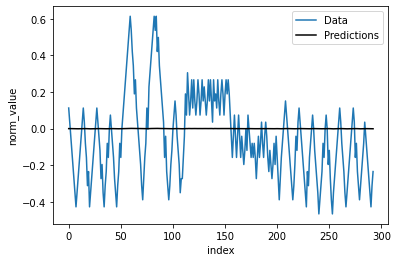

In [54]:
x=pd.DataFrame(test_labels.reshape(test_labels.shape[0],test_labels.shape[1]))
y=pd.DataFrame(result.reshape(result.shape[0],result.shape[1]))
plt.plot(x.index, x[0], label='Data')
plt.plot(y.index, y[0], color='k', label='Predictions')
plt.xlabel('index')
plt.ylabel('norm_value')
plt.legend()
plt.show()

In [55]:
# model.save("./exported_models/LSTM_single_series")
print("Finish")
# converter = tf.lite.TFLiteConverter.from_saved_model("./exported_models/LSTM_single_series")
# tflite_model = converter.convert()
# open("./exported_models/tflite_model/LSTM_single_series.tflite", "wb").write(tflite_model)

Finish


In [56]:
# new_model = tf.keras.models.load_model("./exported_models/LSTM_single_series")

In [57]:
# result_new = new_model.predict(test_features, batch_size=1, verbose=0)
# print(result_new.shape)

In [22]:
# x=pd.DataFrame(test_labels.reshape(test_labels.shape[0],test_labels.shape[1]))
# y=pd.DataFrame(result_new.reshape(result_new.shape[0],result_new.shape[1]))
# plt.plot(x.index, x[0], label='Data')
# plt.plot(y.index, y[0], color='k', label='Predictions')
# plt.xlabel('index')
# plt.ylabel('norm_value')
# plt.legend()
# # plt.show()

In [61]:
from sklearn.metrics import explained_variance_score
y_true = np.array(x[0])
y_pred = np.array(y[0])
explained_variance_score(y_true, y_pred)

0.0037798358644068886

In [62]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
mlflow.log_metric("MSE",mse)
mlflow.log_param("test", 'test line 301-600')

In [63]:
mse

0.05242604565406724

In [25]:

# converter = tf.lite.TFLiteConverter.from_saved_model("./exported_models/LSTM_single_series",signature_keys=['serving_default'])
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.experimental_new_converter = True
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

In [26]:
# tflite_model = converter.convert()
# open("./exported_models/tflite_model/LSTM_single_series.tflite", "wb").write(tflite_model)

NameError: name 'converter' is not defined

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("./exported_models/LSTM_single_series") # path to the SavedModel directory
# tflite_model = converter.convert()

In [ ]:
# with open('LSTM_single_series.tflite', 'wb') as f:
#   f.write(tflite_model)